In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Dùng thư viện yfinance để tải dataset 
import yfinance as yf

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
import math

In [4]:
df = pd.read_csv('DOGE-USD.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-01,0.002346,0.002392,0.002322,0.002392,0.002392,17364744
1,2019-01-02,0.002388,0.002458,0.002372,0.002407,0.002407,18015392
2,2019-01-03,0.002404,0.002414,0.002356,0.002360,0.002360,17619234
3,2019-01-04,0.002364,0.002397,0.002274,0.002315,0.002315,19530100
4,2019-01-05,0.002320,0.002350,0.002280,0.002319,0.002319,17148586


**<h3>ARIMA 7-2-1</h3>**

In [5]:
df = df[['Date', 'Close']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
print(df)

               Close
Date                
2019-01-01  0.002392
2019-01-02  0.002407
2019-01-03  0.002360
2019-01-04  0.002315
2019-01-05  0.002319
...              ...
2023-05-01  0.078820
2023-05-02  0.078806
2023-05-03  0.079713
2023-05-04  0.078449
2023-05-05  0.078835

[1586 rows x 1 columns]


In [6]:
print(len(df))
print(len(train_data))
print(train_size)

1586
1110
1110


In [7]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.4 MB/s eta 0:00:00


In [8]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6131.381, Time=3.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6105.019, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6121.265, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6118.506, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6106.894, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6136.842, Time=5.76 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6130.647, Time=1.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6122.453, Time=2.46 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-6150.403, Time=3.78 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-6152.419, Time=7.69 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-6150.438, Time=4.54 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-6153.239, Time=4.66 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-6173.843, Time=4.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-6175.631, Time=2.50 sec
 ARIMA(3,1,3)(0,0,0

ARIMA(order=(5, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [9]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [10]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
print(last_index)
next_30_days_index = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index)
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(next_30_days_index).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days)) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

2023-05-05 00:00:00
DatetimeIndex(['2023-05-06', '2023-05-07', '2023-05-08', '2023-05-09',
               '2023-05-10', '2023-05-11', '2023-05-12', '2023-05-13',
               '2023-05-14', '2023-05-15', '2023-05-16', '2023-05-17',
               '2023-05-18', '2023-05-19', '2023-05-20', '2023-05-21',
               '2023-05-22', '2023-05-23', '2023-05-24', '2023-05-25',
               '2023-05-26', '2023-05-27', '2023-05-28', '2023-05-29',
               '2023-05-30', '2023-05-31', '2023-06-01', '2023-06-02',
               '2023-06-03', '2023-06-04'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
[0.18493815 0.18603158 0.18485263 0.18320904 0.17913313 0.17767769
 0.17831072 0.1789452  0.1808943  0.18318254 0.18337819 0.18277318
 0.18209167 0.18052542 0.17946963 0.17976113 0.18021862 0.18088605
 0.18192896 0.1822453  0.18187692 0.18153405 0.18096699 0.1803942
 0.180432   0.18072983 0.1809968  0.18141211 0.18165067 0.18149642]


In [11]:
# 12. Đánh giá độ chính xác thuật toán
import sklearn.metrics as metrics
mae = mean_absolute_error(y_test,y_pred)
print('MAE:', mae)

MAE: 0.084831451072551


In [12]:
mse = mean_squared_error(y_test,y_pred)
print('MSE:', mse)

MSE: 0.008385331549961501


In [13]:
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
print('RMSE:', rmse)

RMSE: 0.09157145597816768


In [14]:
r2 = r2_score(y_test, y_pred)
print('r2:', r2)

r2: -6.025548017448988


In [15]:
def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape
mape = mape(y_test, y_pred)
print('MAPE:', mape)

MAPE: 1.1241962204842326


Validation RMSE: 0.09907615805507057
Testing RMSE: 0.09157145597816768
Validation MAPE: 1.2203668810901127
Testing MAPE: 1.1241962204842326


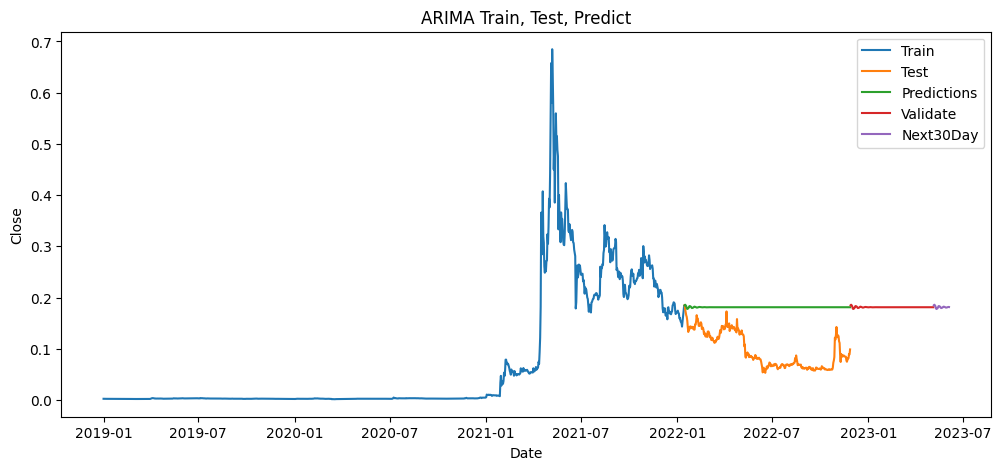

In [16]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('ARIMA Train, Test, Predict')
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
plt.plot(next_30_days_index,y_next_30_days)

plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()